<a href="https://colab.research.google.com/github/kavyajeetbora/monitoring_water_surface_area/blob/master/notebooks/monitoring_inland_water_area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitoring Inland Surface Water Area

In [68]:
import geemap
import ee
import shapely
from datetime import datetime
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Area of Interest

Used this tool to create a geojson file of the area of interest:

[keene Polyline Tool](https://www.keene.edu/campus/maps/tool/?coordinates=77.1200409%2C%2011.5324541%0A76.9923248%2C%2011.5062217%0A76.9916382%2C%2011.3467571%0A77.1529998%2C%2011.4261642%0A77.1200409%2C%2011.5324541)

In [118]:
geojson  = {
  "coordinates": [
    [
      [
        77.1200409,
        11.5324541
      ],
      [
        76.9941101,
        11.5006165
      ],
      [
        76.9701462,
        11.4243672
      ],
      [
        77.0055084,
        11.3198347
      ],
      [
        77.1529998,
        11.4261642
      ],
      [
        77.1200409,
        11.5324541
      ]
    ]
  ],
  "type": "Polygon"
}

geometry = ee.Geometry(geojson)

## Download images from google earth

In [126]:
def getImageCollection(image_id, dates, geometry, cloud_cover):
    d1,d2 = dates
    ic = ee.ImageCollection(image_id)\
    .filter(ee.Filter.date(d1,d2))\
    .filter(ee.Filter.bounds(geometry))\
    .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))

    return ic

def preprocess_landsat(image:ee.image.Image) -> ee.image.Image:
    '''
    This function will choose only the required bands
    also rescale the reflectance value to original
    and calculate the indices: NDWI
    '''

    ## Select and rescale
    bands = image.select("SR_*").multiply(2.75e-05).add(-2)

    ## Calculate the NDWI
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return ndwi.copyProperties(image, image.propertyNames())


class AggregateImageCollection():
    def __init__(self, image_collection):
        self.image_collection = image_collection

    def extract_year(self, image, prop="system:time_start"):
        '''Extract the year from a given image'''
        year = ee.Date(image.get(prop)).get('year')
        return image.set('year', year)

    def aggregate_image_by_year(self, year):
        '''Aggregate the image collection by year'''
        yearlyImages = self.image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        yearlyImages = yearlyImages.median()
        return yearlyImages.set('year', year)

    def aggregate_image_collection_by_year(self):
        years = self.image_collection.map(self.extract_year).aggregate_array('year').distinct().sort()
        agg_images = years.map(lambda x: self.aggregate_image_by_year(x))
        return ee.ImageCollection(agg_images)

def calculate_surface_water_area(image, geometry, threshold=0.2):

    thr = image.select('NDWI').gt(threshold)
    ndwi_masked = thr.updateMask(thr)

    ## Calculate the area
    pixel_area = ndwi_masked.multiply(ee.Image.pixelArea().divide(1e6))

    ## Calculate the total area
    water_area = pixel_area.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = geometry,
        scale = 10
    )
    water_area = water_area.get('NDWI')

    image = image.set('water_surface_area_KM2', water_area)

    return image.addBands([ndwi_masked])

def extract_time_series(image_collection, stat='water_surface_area_KM2'):
    '''
    Extract timeseries values, the average values and the time
    here time will be converted to python datetime object
    It will set as none where average value is not found
    '''

    image_list = agg_lc_area.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    xs, ys = [], []
    for prop in properties:
        x,y = prop['year'], prop[stat]
        xs.append(x), ys.append(y)

    return xs, ys

def plot_time_series(x,y):
    '''
    Plot the time series given the x - datetime, y- stat
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(x,y)
    ax.set_xlabel("Year")
    ax.set_ylabel('Surface Water Area (KM2)')
    ax.set_title("Total Surface Water Area")
    return fig

### Download the satellite image collection

In [119]:
cloud_cover = 5
dates = ("1999-01-01", "2025-01-01")
image_ids = ["LANDSAT/LE07/C02/T1_L2", "LANDSAT/LC08/C02/T1_L2","LANDSAT/LC09/C02/T1_L2"]

lc = None

for i, image_id in enumerate(image_ids):
    lc_images = getImageCollection(
        image_id = image_id,
        dates = dates,
        geometry = geometry,
        cloud_cover = cloud_cover
    )
    if i == 0:
        lc = lc_images
    else:
        lc = lc.merge(lc_images)

lc.size()

### Caculate the NDWI indices

In [120]:
processed_lc = lc.map(lambda image:preprocess_landsat(image))

### Aggreate the image collection by median for every year

In [121]:
aggregator = AggregateImageCollection(processed_lc)
agg_lc = aggregator.aggregate_image_collection_by_year()
agg_lc.size()

### Calculate the surface water area

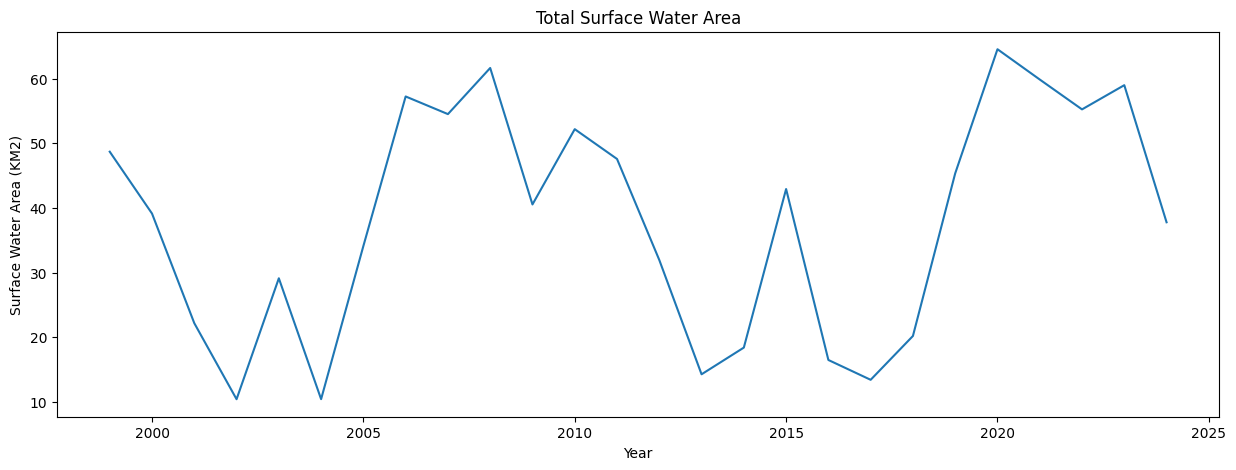

In [128]:
threshold=0
agg_lc_area = agg_lc.map(lambda x: calculate_surface_water_area(x, geometry, threshold))
xs,ys = extract_time_series(agg_lc_area)
fig = plot_time_series(xs,ys)

### Visualize the time series on map

In [129]:
Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#ece7f2','#a6bddb','#2b8cbe']
}
Map.addLayer(agg_lc_area.first().select('NDWI_1').clip(geometry), vis_params, "Surface Water")
Map.centerObject(geometry, zoom=12)
Map

Map(center=[11.437008883357802, 77.05579366889911], controls=(WidgetControl(options=['position', 'transparent_…

In [130]:
Map = geemap.Map()

vis_params = {'min': -1, 'max': 1, 'palette': ['#ece7f2','#a6bddb','#2b8cbe']}

Map.add_time_slider(agg_lc_area.select('NDWI_1'), vis_params, labels=list(map(str,xs)), time_interval=1)
Map.centerObject(geometry, zoom=12)
Map

Map(center=[11.437008883357802, 77.05579366889911], controls=(WidgetControl(options=['position', 'transparent_…